## Load DataFrame

In [5]:
%matplotlib inline
import pandas as pd
from pathlib import Path
import os
import json
from constants import TEXTS_DIR, TOXICITY_SCORES_PICKLE, PERSPECTIVE_API_LEN_LIMIT, PERSPECTIVE_API_ATTRIBUTES, PERSPECTIVE_API_RESPONSE_DIR, URLS_PICKLE, DATA_DIR

In [6]:
# Load Perspective API responses into dataframe
ATTRIBUTE_COLUMNS = [a.lower() for a in PERSPECTIVE_API_ATTRIBUTES]

def load_api_responses():
    if not TOXICITY_SCORES_PICKLE.exists():
        rows = []

        for toxicity_file in PERSPECTIVE_API_RESPONSE_DIR.iterdir():
            if toxicity_file.suffix != '.json':
                continue            

            # load toxicity score
            toxicity_json = json.load(toxicity_file.open())
            scores = []
            for attribute in PERSPECTIVE_API_ATTRIBUTES:
                try:
                    score = toxicity_json['attributeScores'][attribute]['summaryScore']['value']
                except:
                    score = None
                scores.append(score)

            # split filename
            basename, *exts = toxicity_file.name.split(os.extsep)
            assert exts[0] == 'txt' and exts[-1] == 'json'

            # load text
            chunk_num = int(exts[1].split('-')[1]) if len(exts) == 3 else 0
            text_filename = basename + '.' + exts[0]
            text = (TEXTS_DIR / text_filename).read_text()[PERSPECTIVE_API_LEN_LIMIT * chunk_num: PERSPECTIVE_API_LEN_LIMIT * (chunk_num + 1)]

            rows.append([text_filename, text, chunk_num, *scores])

        df = pd.DataFrame(rows, columns=['filename', 'text', 'chunk_num', *ATTRIBUTE_COLUMNS])

        # Save a pickle for later
        df.to_pickle(TOXICITY_SCORES_PICKLE)
    else:
        df = pd.read_pickle(TOXICITY_SCORES_PICKLE)

    urls = pd.read_pickle(URLS_PICKLE)
    return df.merge(urls, how='left')


df = load_api_responses()

## Basic Analysis

In [3]:
ATTRIBUTE_COLUMNS

['toxicity',
 'severe_toxicity',
 'identity_attack',
 'insult',
 'threat',
 'profanity',
 'sexually_explicit',
 'flirtation']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d5e2e3cd0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d88353790>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1cae10cd50>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d88353650>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1cae1ac1d0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1cae1a1410>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1cae1c4850>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1cae213510>]],
      dtype=object)

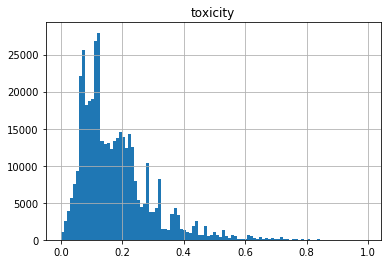

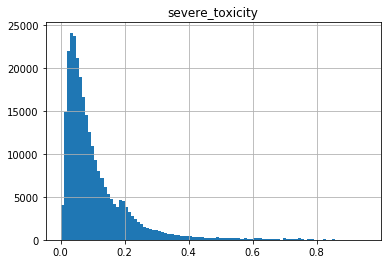

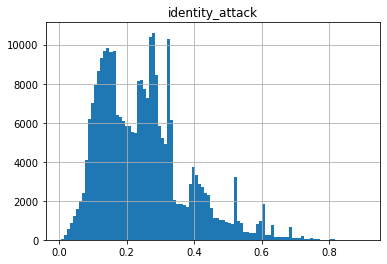

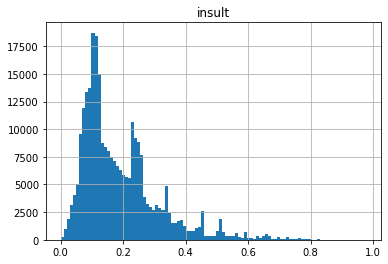

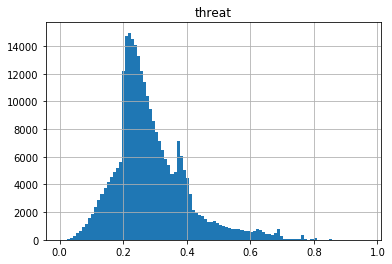

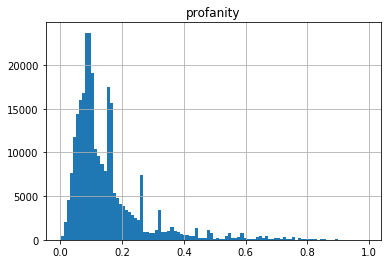

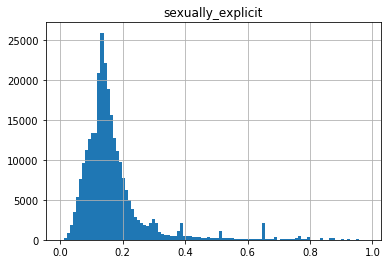

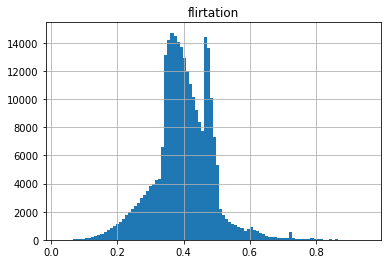

In [4]:
# Histogram of toxicity scores
for a in ATTRIBUTE_COLUMNS:
    display(df.hist(column=a, bins=100))

In [12]:
# Data sorted by toxicity
df.sort_values(by=['identity_attack'], ascending=False).head()

,filename,text,chunk_num,toxicity,severe_toxicity,identity_attack,insult,threat,profanity,sexually_explicit,flirtation,url,domain
303908,0100405-6988e5035a9b17affda427a58b63ac23.txt,"Nigger Music consists of Hip Hop and Rap, Most...",0,0.871854,0.855551,0.906385,0.900344,0.742614,0.859574,0.305453,0.493827,NaN,NaN
184148,0784321-c5d912099845799b9f15f1b676b0067e.txt,Wow! I can't believe you are so hurt! I've see...,0,0.832870,0.779229,0.889870,0.827652,0.687052,0.756411,0.157658,0.466608,https://archive.is/9GMoU,archive.is
220713,0493333-a6f2a2e0e19e3a41e1c302ee74a7f7a4.txt,A black teenager used Facebook Live to reveal ...,0,0.802834,0.854638,0.877267,0.839415,0.530163,0.823162,0.762413,0.645599,NaN,NaN
390772,0005792-55b0464d4abd3a1820d6af774412ffef.txt,With the upcoming debut of Eminem’s Battle Rap...,0,0.871712,0.821408,0.870191,0.901071,0.807092,0.893975,0.366037,0.514029,http://www.hiphopdx.com/index/news/id.28794/ti...,hiphopdx.com
273598,0559481-1c6576e0fc8dff7463ac1678b7b0b321.txt,The bloodthirsty Twitter lynch mob is at it ag...,0,0.790971,0.826633,0.861004,0.817971,0.868598,0.790423,0.396864,0.624161,http://twitchy.com/2013/06/27/ima-kill-me-a-cr...,twitchy.com


In [18]:
[x[:100] for x in df.sort_values(by=['severe_toxicity'], ascending=False).head(30)['text']]

["Me: Look at this cool picture I drew!John: It looks like it's worthy of a Nobel Piece of Shit Prize!",
 'Danny is a character in Trailer Park Boys that is heard, but almost never seen. Nearly all of his (s',
 "▼: now where could i find some motherfucking paint?▲: OH, FUCK.▼: I DIDN'T SEE YOU THERE KARKAT▲: OH",
 "Dashing through the snow\n\nGet the fuck out of my way\n\nYou're so fucking slow\n\nAnd fat, what do you w",
 "“See that wall right there? I'm gonna punch a fucking hole through it, and I’d love to see you try a",
 'Americans love to curse, no fucking question. Fuck this, fuck that, bitchass motherfucking cuntsucke',
 '\n\nFlame Mail\n\nGreatest Hits\n\n\n\nHere we collect the finest pieces of flame mail ever to reach our in-',
 ' people HATE WAITING as to why ALL of these things happened to me. Especially the lady that I wrote ',
 't. Also, please ta be shizzle not ta make any mistakes. This last collection, tha witchz ass is stra',
 "Fucking dumb assholes. Typical brain de

In [19]:
[x[:100] for x in df.sort_values(by=['identity_attack'], ascending=False).head(30)['text']]

['Nigger Music consists of Hip Hop and Rap, Most "so called" songs are a combination of elements rippe',
 "Wow! I can't believe you are so hurt! I've seen the error of my ways! Please help me! ......you shou",
 "A black teenager used Facebook Live to reveal just how ugly racism is at a Chester's in San Antonio,",
 'With the upcoming debut of Eminem’s Battle Rap tournament event Total Slaughter impending, battler D',
 'The bloodthirsty Twitter lynch mob is at it again. If George Zimmerman isn’t found guilty of murderi',
 'the best thing for white men to do? in the interest of decolonization, radical liberation, anti-raci',
 "If we want our views to become more mainstream, don't be shy when you're asked about your views on c",
 'Mac Miller might have come up off the success of his song "Donald Trump," but these days the Pittsbu',
 '[Intro: Pusha T & DJ Khaled]\n\nYeah\n\nWe the Best Music!\n\nDJ Khaled!\n\n\n\n[Verse 1: Pusha T]\n\nPlease, Kh',
 'Dear Racist Assholes,\n\nYou’re dying. Ev

# TF-IDF

In [ ]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["text"])

feature_names = vectorizer.get_feature_names()

In [ ]:
df_idf = pd.DataFrame(vectorizer.idf_, index=feature_names, columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights'], ascending=False).head()

In [ ]:
def get_idf_score(filename):
    idx = df[df['filename'] == filename].index
    document_vector = X[idx]
    df_tfidf = pd.DataFrame(document_vector.T.todense(), index=feature_names, columns=["tfidf"])
    return df_tfidf.sort_values(by=["tfidf"],ascending=False)

In [ ]:
get_idf_score('0189902-976e23a79df312f42c99556b1efe11e1.txt').head()

In [ ]:
get_idf_score('0672031-2e34d061fc3c5e59d8730115bf3ef6b5.txt').head()